<a href="https://colab.research.google.com/github/alejandrocorrealoaiza1/Analisis-exploratorio-precios-de-casas/blob/main/Copia_de_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-01-FUNDAMENTOS/master/init.py
import init; init.init(force_download=False); 

replicating local resources


# Precios de Casas

El objetivo de este taller es realizar un análisis exploratorio de un dataset. El dataset no llega limpio, el proceso de limpieza se encuentra implementado. Después de este proceso de limpieza se debe llevar a cabo el análisis exploratorio.

In [2]:
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Entendiendo y limpiando el dataset

La descripcion de cada variable puede verse ejecutando la siguiente celda

In [3]:
!cat local/data/houseprices_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

Ahora carguemos los datos y hagamos una breve exploración

In [4]:
df = pd.read_csv("local/data/houseprices.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Podemos ver que hay una gran cantidad de valores nulos en algunas de las variables. Alguien, algo despistado, podría sugerir simplemente eliminar esas variables; sin embargo, la descripción de las variables que observamos anteriormente, nos permite entender la razón de ser de estos valores nulos y tratarlos de una manera inteligente. Por ejemplo, consideremos la variable `PoolQC` la cual nos muestra únicamente 7 valores no nulos de los 1460 registros que tenemos en total. Su descripción dice:

```
PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

```

Esta variable hace referencia a la calidad de la piscina en la casa y vemos que `NA` significa que no tiene piscina, lo cual posiblemente tiene mucho impacto en el precio de una casa (pregúntese, ¿estaría dispuesto a pagar más por una casa que tenga piscina?). Además, vemos que existe la variable `PoolArea`, la cual almacena el area de la piscina en $ft^2$, la cual no tiene valores nulos. Dado esto, los valores nulos de la variable `PoolQC` deben corresponder a casos en los que la variable `PoolArea` es cero; validemos esto.

In [6]:
num_total_nulls = df["PoolQC"].isna().sum()
num_nulls_when_poolarea_is_zero = df[df["PoolArea"] == 0]["PoolQC"].isna().sum()
assert num_nulls_when_poolarea_is_zero == num_total_nulls


In [7]:
num_nulls_when_poolarea_is_not_zero = df[df["PoolArea"] != 0]["PoolQC"].isna().sum()
assert num_nulls_when_poolarea_is_not_zero == 0

Concluimos que se cumple que todos los valores nulos de la variable `PoolQC` corresponden a casos en los que no hay piscina; por lo tanto, vamos a reemplzar los valores nulos por otro valor que podamos usar en nuestros modelos.

In [8]:
df["PoolQC"] = df["PoolQC"].fillna("NP")

Esta misma lógica debemos usarla a la hora de tratar el resto de las variables con valores nulos de este dataset. Escribiremos algún razonamiento addiconal únicamente cuando haga falta

In [9]:
num_total_nulls = df["MiscFeature"].isna().sum()
num_nulls_when_miscval_is_zero = df[df["MiscVal"] == 0]["MiscFeature"].isna().sum()
num_nulls_when_miscval_is_not_zero = df[df["MiscVal"] != 0]["MiscFeature"].isna().sum()
assert num_nulls_when_miscval_is_zero == num_total_nulls
assert num_nulls_when_miscval_is_not_zero == 0
df["MiscFeature"] = df["MiscFeature"].fillna("No MF")

In [10]:
num_total_nulls = df["FireplaceQu"].isna().sum()
num_nulls_when_fireplaces_is_zero = df[df["Fireplaces"] == 0]["FireplaceQu"].isna().sum()
num_nulls_when_fireplaces_is_not_zero = df[df["Fireplaces"] != 0]["FireplaceQu"].isna().sum()
assert num_nulls_when_fireplaces_is_zero == num_total_nulls
assert num_nulls_when_fireplaces_is_not_zero == 0
df["FireplaceQu"] = df["FireplaceQu"].fillna("No FP")

In [11]:
num_area_zeros = (df["GarageArea"] == 0).sum()
num_cars_zeros = (df["GarageCars"] == 0).sum()
num_both_zeros = ((df["GarageArea"] == 0) & (df["GarageCars"] == 0.0)).sum()
assert num_both_zeros == num_area_zeros == num_cars_zeros
for colname in ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]:
    num_total_nulls = df[colname].isna().sum()
    num_nulls_when_area_and_cars_capacity_is_zero = df[(df["GarageArea"] == 0.0) & (df["GarageCars"] == 0.0)][colname].isna().sum()
    num_nulls_when_area_and_cars_capacity_is_not_zero = df[(df["GarageArea"] != 0.0) & (df["GarageCars"] != 0.0)][colname].isna().sum()
    assert num_total_nulls == num_nulls_when_area_and_cars_capacity_is_zero
    assert num_nulls_when_area_and_cars_capacity_is_not_zero == 0
    df[colname] = df[colname].fillna("No Ga")

Para la variable `GarageYrBlt` debemos ser más cuidadosos, ya que son números y no strings. Esta variable nos dice el año en que fue construido el garaje y, según lo visto con otras variables relacionadas al garage, los valores nulos corresponden a casos en los que no hay garage. En este caso, vamos a imputar esa variable con un año posterior a la fecha de venta. Esta aproximación podría no funcionar muy bien con modelos lineales, o cuando escalamos los datos, pero no se me ocurre otra!

In [12]:
num_total_nulls = df["GarageYrBlt"].isna().sum()
num_nulls_when_area_and_cars_is_zero = df[(df["GarageArea"] == 0.0) & (df["GarageCars"] == 0.0)]["GarageYrBlt"].isna().sum()
num_nulls_when_area_and_cars_is_not_zero = df[(df["GarageArea"] != 0.0) & (df["GarageCars"] != 0.0)]["GarageYrBlt"].isna().sum()
assert num_nulls_when_area_and_cars_is_zero == num_total_nulls
assert num_nulls_when_area_and_cars_is_not_zero == 0
df["GarageYrBlt"].where(~df["GarageYrBlt"].isna(), other=df["YrSold"] + 1, inplace=True)

`LotFrontage: Linear feet of street connected to property)`

Valores nulos en esta variable podrían ser ocasionados porque sencillamente no hay conexión de la calle a la propiedad, es decir, que esa longitud medida por esta variable es igual a 0. Podemos asumir que este es el caso únicamente si no hay otro 0 en los valores que ha tomado esta variable, de otra manera ¿por qué algunos tendrían 0 y otros nulos?

In [13]:
assert (df["LotFrontage"] == 0).sum() == 0
df["LotFrontage"].fillna(0, inplace=True)

In [14]:
df["Alley"].fillna("NA", inplace=True)
df["Fence"].fillna("NF", inplace=True)

```
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
	
MasVnrArea: Masonry veneer area in square feet
```

Una posibilidad es que los valores nulos de `MasVnrType` y `MasVnrArea` correspondan a casos en los que no hay "Masonry veneer" (chapa de albañilería). Esto sería en los casos en que la variable `MasVnrArea` sea 0, esto lo validaremos de la misma manera en que validamos con la variable `LotFrontage`.

In [15]:
assert (df["MasVnrArea"] == 0).sum() == df["MasVnrType"].isnull().sum()

AssertionError: ignored

Acá la situación es diferente, el error anterior nos dice que los casos para los cuales no tenemos área son distintos de los que el tipo es nulo, entonces nos toca inspeccionar más en detalle. Sabemos que hay 8 valores nulos en cada una de las dos variables, miremos si corresponden a los mismos registros:

In [16]:
np.logical_and(df["MasVnrType"].isnull().values, df["MasVnrArea"].isnull().values).sum()

8

En efecto, dado que hay 8 registros para los cuales las dos variables tienen valores nulos, podemos decir que son nulos en ambas partes. A falta de información, vamos a decidir eliminar esos registros por completo, no debe ser muy grave, pues apenas son 8 filas en todo el dataset.

In [17]:
df = df.dropna(subset=["MasVnrType", "MasVnrArea"])

Ahora miremos los valores de cada una

In [18]:
df["MasVnrType"].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [19]:
df["MasVnrArea"].value_counts()

0.0      861
180.0      8
72.0       8
108.0      8
120.0      7
        ... 
562.0      1
89.0       1
921.0      1
762.0      1
119.0      1
Name: MasVnrArea, Length: 327, dtype: int64

Acá podemos observar lo siguiente:
- Hay 864 registros con `MasVnrType="None"`
- Hay 861 registros con `MasVnrArea=0`

Eso quiere decir que hay algunos registros que deberían tener un área de 0 y no es así. Vamos a mirar en detalle cuáles son:

In [20]:
df[(df["MasVnrType"] == "None") & (df["MasVnrArea"] != 0.0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
624,625,60,RL,80.0,10400,Pave,NA,Reg,Lvl,AllPub,...,0,NP,NF,No MF,0,11,2006,WD,Normal,165150
773,774,20,RL,70.0,10150,Pave,NA,Reg,Lvl,AllPub,...,0,NP,NF,No MF,0,7,2007,COD,Normal,114500
1230,1231,90,RL,0.0,18890,Pave,NA,IR1,Lvl,AllPub,...,0,NP,NF,Gar2,8300,8,2007,WD,Normal,190000
1300,1301,60,RL,0.0,10762,Pave,NA,IR1,Lvl,AllPub,...,0,NP,NF,No MF,0,5,2009,WD,Normal,225000
1334,1335,160,RM,24.0,2368,Pave,NA,Reg,Lvl,AllPub,...,0,NP,NF,No MF,0,5,2009,WD,Normal,125000


**Francamente** yo no soy un experto en casas, por lo que no tengo forma de deducir a qué se debe esa incoherencia en los datos. Por lo anterior, simplemente voy a eliminar esas filas, ya que tengo dudas de la veracidad de esos datos.

In [21]:
df = df[~((df["MasVnrType"] == "None") & (df["MasVnrArea"] != 0.0))]

La variable `Electrical` tampoco nos ofrece una forma de recuperar esos valores nulos, por lo que también vamos a eliminar ese registro. Nótese que otra opción podría ser reemplazarlo con el valor más común en la misma variable, dado que esta es categórica. 

In [22]:
df.dropna(subset=["Electrical"], inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1446 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1446 non-null   int64  
 1   MSSubClass     1446 non-null   int64  
 2   MSZoning       1446 non-null   object 
 3   LotFrontage    1446 non-null   float64
 4   LotArea        1446 non-null   int64  
 5   Street         1446 non-null   object 
 6   Alley          1446 non-null   object 
 7   LotShape       1446 non-null   object 
 8   LandContour    1446 non-null   object 
 9   Utilities      1446 non-null   object 
 10  LotConfig      1446 non-null   object 
 11  LandSlope      1446 non-null   object 
 12  Neighborhood   1446 non-null   object 
 13  Condition1     1446 non-null   object 
 14  Condition2     1446 non-null   object 
 15  BldgType       1446 non-null   object 
 16  HouseStyle     1446 non-null   object 
 17  OverallQual    1446 non-null   int64  
 18  OverallC

Ahora miremos las variables relacionadas con el basement:

```

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

```

Dado que los valores nulos en varias de estas variables corresponden a `No Basement`, ahora miremos si los registros nulos en algunas corresponden a los registros nulos en todas. Primero, dado que ya hemos eliminado varios registros, vamos a ver cuántos valores nulos hay en esas variables.

In [24]:
colnames = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
    "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]
for c in colnames:
    print(f"{c} has {df[c].isnull().sum()} null values")

BsmtQual has 37 null values
BsmtCond has 37 null values
BsmtExposure has 38 null values
BsmtFinType1 has 37 null values
BsmtFinSF1 has 0 null values
BsmtFinType2 has 38 null values
BsmtFinSF2 has 0 null values
BsmtUnfSF has 0 null values
TotalBsmtSF has 0 null values


In [25]:
df["TotalBsmtSF"].value_counts()

0       37
864     35
672     17
912     14
1040    14
        ..
1581     1
707      1
611      1
1452     1
1542     1
Name: TotalBsmtSF, Length: 716, dtype: int64

Acá vemos que algunas tienen más variables nulas que otras, lo cual es confuso porque en cualquier caso los valores nulos deberían significar que no hay basement. En este caso vamos a reemplazar los valores en los que los valores nulos sean en todas las variables no numéricas pero los que sobren los eliminaremos.

In [26]:
colnames = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
cond = ~(df["BsmtQual"].isna() & df["BsmtCond"].isna() & df["BsmtExposure"].isna() & df["BsmtFinType1"].isna() & df["BsmtFinType2"].isna())
for c in colnames:
    df[c].where(cond, other="NB", inplace=True)

In [27]:
df.dropna(inplace=True)
print(f"Number of null values {df.isna().sum().sum()} in a dataframe of shape {df.shape}")

Number of null values 0 in a dataframe of shape (1444, 81)


## Análisis exploratorio de datos

En esta sección se dejarán preguntas que deben ser respondidas utilizando los datos.

**¿Qué tan viejas son las casas?**

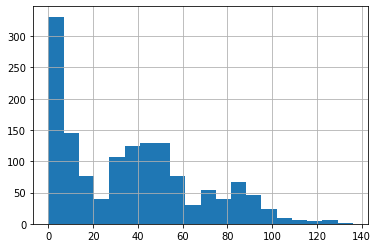

In [28]:
df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
df["HouseAge"].hist(bins=20)

In [29]:
df2 = pd.DataFrame(df[["YearBuilt","YrSold"]])
df2["HouseAge"] = df2["YrSold"] - df2["YearBuilt"]
df2

,YearBuilt,YrSold,HouseAge
0,2003,2008,5
1,1976,2007,31
2,2001,2008,7
3,1915,2006,91
4,2000,2008,8
...,...,...,...
1455,1999,2007,8
1456,1978,2010,32
1457,1941,2010,69
1458,1950,2010,60


In [30]:
mean_house_age= np.mean(df["HouseAge"])
min_house_age = np.min(df["HouseAge"])
max_house_age = np.max(df["HouseAge"])
print(f' las casas están entre los {min_house_age} años y {max_house_age} años, con un promedio de {mean_house_age} años')

 las casas están entre los 0 años y 136 años, con un promedio de 36.78185595567867 años


**¿Cómo se relaciona el precio con la edad de la casa?**

In [31]:
df3 = pd.DataFrame(df["SalePrice"])
df3["HouseAge"] = df2["YrSold"] - df2["YearBuilt"]
df3

,SalePrice,HouseAge
0,208500,5
1,181500,31
2,223500,7
3,140000,91
4,250000,8
...,...,...
1455,175000,8
1456,210000,32
1457,266500,69
1458,142125,60


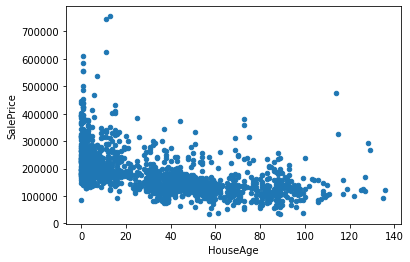

In [32]:
df3.plot('HouseAge','SalePrice', kind = 'scatter')

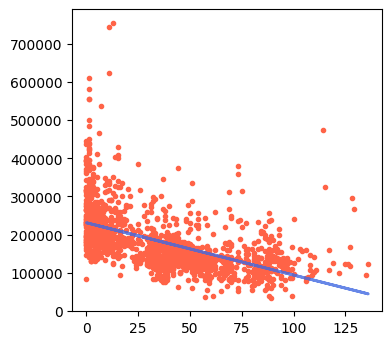

In [33]:
x = df3.HouseAge
y = df3.SalePrice

fig, ax = plt.subplots(figsize=(4, 4), dpi=100) 

ax.plot(x, y,
        linestyle='None', marker='.', color='tomato',  # estilo de línea
        zorder=2)  # orden para colocar sobre rejilla

z = np.polyfit(x, y, 1)  # ajuste polinómico de grado 1
p = np.poly1d(z)
plt.plot(x, p(x), linewidth=2, alpha=0.8, color='royalblue')

R/ = Graficamente se puede observar que las casas más nuevas podrían tener un valor más alto de venta, sin ambargo no hay una relación muy fuerte entre estas dos variabales.

**¿Cuál es el barrio más pobre?**

In [34]:
df4 = pd.DataFrame(df[["Neighborhood","SalePrice"]])
df5 = df4.groupby(by = "Neighborhood").mean().sort_values(by = "SalePrice")
df5

,SalePrice
Neighborhood,
MeadowV,98576.470588
IDOTRR,100123.783784
BrDale,103126.666667
BrkSide,124834.051724
Edwards,128219.700000
OldTown,128225.300885
Sawyer,136064.273973
Blueste,137500.000000
SWISU,142591.360000


R/ A trvés de los datos se puede inferir que las casas con menores condiciones y menos lujos tienen un precio menor, por lo cuál una barrio donde el promedio de los precios es más bajo tiene pobres condiciones, ejemplo MeadowV y IDOTRR

**¿Cuál es el barrio más cercano a vías férreas?**

In [35]:
df6 = pd.DataFrame(df[["Neighborhood","Condition1","Condition2"]])
proximity_railroad = df6[(df6.Condition1.isin(["RRNn","RRAn","RRNe","RRAe"]) | df6.Condition2.isin(["RRNn","RRAn","RRNe","RRAe"]))]
proximity_railroad['Contar'] = 1
proximity_railroad

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Neighborhood,Condition1,Condition2,Contar
18,SawyerW,RRAe,Norm,1
29,BrkSide,Feedr,RRNn,1
52,IDOTRR,RRNn,Norm,1
60,SawyerW,RRAe,Norm,1
63,OldTown,RRAn,Feedr,1
144,Sawyer,RRAe,Norm,1
184,BrkSide,RRAn,Feedr,1
206,Sawyer,RRAe,Norm,1
222,NWAmes,RRAn,Norm,1
237,SawyerW,RRNe,Norm,1


In [36]:
proximity_railroad.groupby( by = "Neighborhood").sum('Contar').sort_values(by = 'Contar', ascending = False)

,Contar
Neighborhood,
BrkSide,9
Gilbert,9
NWAmes,7
Sawyer,6
SawyerW,6
Somerst,6
IDOTRR,2
OldTown,2


R/ = Los barrios más cercanos a vías ferreas son BrkSide y Giilbert

**¿Cuál es la cobertura más común en las casas que se encuentran el el top 10% en precio?**

In [132]:
cobertura = pd.DataFrame(df[["Id","SalePrice","Exterior1st","Exterior2nd"]])
cobertura.sort_values(by = "SalePrice", ascending = False)

,Id,SalePrice,Exterior1st,Exterior2nd
691,692,755000,HdBoard,HdBoard
1182,1183,745000,Wd Sdng,ImStucc
1169,1170,625000,HdBoard,HdBoard
898,899,611657,VinylSd,VinylSd
803,804,582933,VinylSd,VinylSd
...,...,...,...,...
30,31,40000,BrkFace,BrkFace
533,534,39300,VinylSd,VinylSd
968,969,37900,VinylSd,VinylSd
916,917,35311,AsbShng,AsbShng


In [134]:
arry = df[["SalePrice"]]
percentile = np.percentile(arry, 90)

diez_por_ciento = cobertura[cobertura['SalePrice'] >= percentile]
diez_por_ciento 

,Id,SalePrice,Exterior1st,Exterior2nd
6,7,307000,VinylSd,VinylSd
11,12,345000,WdShing,Wd Shng
13,14,279500,VinylSd,VinylSd
20,21,325300,VinylSd,VinylSd
27,28,306000,VinylSd,VinylSd
...,...,...,...,...
1403,1404,282922,VinylSd,VinylSd
1417,1418,340000,VinylSd,VinylSd
1437,1438,394617,VinylSd,VinylSd
1442,1443,310000,VinylSd,VinylSd


In [168]:
cobertura1 = pd.DataFrame(diez_por_ciento.groupby(by = "Exterior1st").size())
cobertura2 = pd.DataFrame(diez_por_ciento.groupby(by = "Exterior2nd").size())

cobertura1 , cobertura2

(              0
 Exterior1st    
 BrkFace       8
 CemntBd      20
 HdBoard       5
 MetalSd       9
 Plywood       5
 Stone         1
 Stucco        2
 VinylSd      85
 Wd Sdng       8
 WdShing       2,               0
 Exterior2nd    
 BrkFace       5
 CmentBd      20
 HdBoard       7
 ImStucc       3
 MetalSd       9
 Other         1
 Plywood       4
 Stucco        1
 VinylSd      83
 Wd Sdng       9
 Wd Shng       3)

R/ la cobertura más común en las casas que se encuentran el el top 10% en precio es la VinylSd

**¿En qué barrio hay mayor desigualdad?**

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


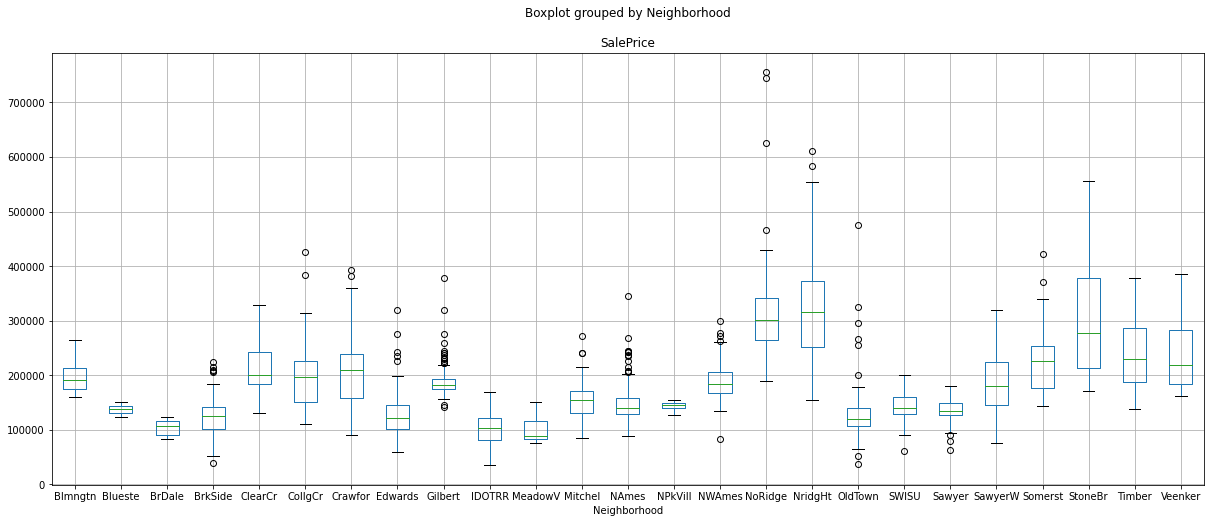

In [108]:
desigualdad = pd.DataFrame(df[["Neighborhood","SalePrice"]])
#desigualdad.groupby( by = "Neighborhood")
bigotes = desigualdad.boxplot(column="SalePrice", by="Neighborhood", figsize = (20,8))
#desigualdad.set_xticklabels(labels, rotation=90)
#bigotes.invert_yaxis()
bigotes

In [104]:
desigualdad.groupby( by = "Neighborhood").std()


,SalePrice
Neighborhood,
Blmngtn,30393.229219
Blueste,19091.883092
BrDale,13710.708363
BrkSide,40348.689270
ClearCr,50231.538993
CollgCr,51649.462283
Crawfor,69550.599180
Edwards,43208.616459
Gilbert,36161.352410


R/ El barrio con más desigualdad es el NoRidge pues presenta una mayor desviación en los precios de las casas

**¿En qué año hubo más movimiento del mercado inmobiliario?**

In [37]:
df_mercado = pd.DataFrame(df.groupby( by = "YrSold").size())
df_mercado

,0
YrSold,
2006,311
2007,325
2008,300
2009,334
2010,174


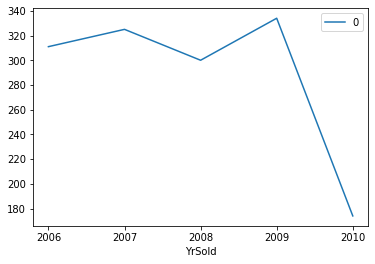

In [41]:
import matplotlib.ticker as ticker
import math
grafica = df_mercado.plot()
plt.xticks(np.arange(2006, 2011))
plt.show()

R/ El año en que hubo más movimiento inmobiliario fue en el 2009 con 334 casa vendidas


**¿Cuáles son los 2 barrios con mayor industria cerca?**

In [40]:
zona = pd.DataFrame(df[["Neighborhood","MSZoning"]])
zona_industrial = zona[(zona.MSZoning.isin(["I"]))]
zona_industrial

,Neighborhood,MSZoning


R/ No hay barrios con industria cerca

**¿Cuáles son los 2 barrios con mayor comercio cerca?**

In [44]:
comercio = pd.DataFrame(df[["Neighborhood","MSZoning"]])
zona_comercial = zona[(zona.MSZoning.isin(["C (all)"]))]
zona_comercial

,Neighborhood,MSZoning
30,IDOTRR,C (all)
88,IDOTRR,C (all)
93,OldTown,C (all)
495,IDOTRR,C (all)
557,IDOTRR,C (all)
711,IDOTRR,C (all)
812,IDOTRR,C (all)
916,IDOTRR,C (all)
1061,IDOTRR,C (all)
1279,IDOTRR,C (all)


R/ Los dos barrios con mayor comercio cerca son IDOTRR Y OldTown